## Closed-loop batch, constrained BO in BoTorch with qEI and qNEI

In this tutorial, we illustrate how to implement a simple Bayesian Optimization (BO) closed loop in BoTorch.

In general, we recommend for a relatively simple setup (like this one) to use Ax, since this will simplify your setup (including the amount of code you need to write) considerably. See the [Using BoTorch with Ax](./custom_botorch_model_in_ax) tutorial.

However, you may want to do things that are not easily supported in Ax at this time (like running high-dimensional BO using a VAE+GP model that you jointly train on high-dimensional input data). If you find yourself in such a situation, you will need to write your own optimization loop, as we do in this tutorial.


We use the batch Expected Improvement (qEI) and batch Noisy Expected Improvement (qNEI) acquisition functions to optimize a constrained version of the synthetic Hartmann6 test function. The standard problem is

$$f(x) = -\sum_{i=1}^4 \alpha_i \exp \left( -\sum_{j=1}^6 A_{ij} (x_j - P_{ij})^2  \right)$$

over $x \in [0,1]^6$ (parameter values can be found in `botorch/test_functions/hartmann6.py`).

In real BO applications, the design $x$ can influence multiple metrics in unknown ways, and the decision-maker often wants to optimize one metric without sacrificing another. To illustrate this, we add a synthetic constraint of the form $\|x\|_1 - 3 \le 0$. Both the objective and the constraint are observed with noise. 

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x} -f(x) = 3.32237$.

In [1]:
import os
from typing import Optional

import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

I0214 132746.769 _utils_internal.py:247] NCCL_DEBUG env var is set to None


I0214 132746.770 _utils_internal.py:265] NCCL_DEBUG is forced to WARN from None


### Problem setup

First, we define the constraint used in the example in `outcome_constraint`. The second function `weighted_obj` is a "feasibility-weighted objective," which returns zero when not feasible. 

In [2]:
from botorch.test_functions import Hartmann


neg_hartmann6 = Hartmann(negate=True)


def outcome_constraint(X):
    """L1 constraint; feasible if less than or equal to zero."""
    return X.sum(dim=-1) - 3


def weighted_obj(X):
    """Feasibility weighted objective; zero if not feasible."""
    return neg_hartmann6(X) * (outcome_constraint(X) <= 0).type_as(X)

#### Model initialization

We use a `MultiOutputGP` to model the objective (output 0) and the constraint (output 1). We assume known homoskedastic observation noise on both the objective and constraint with standard error $\sigma = 0.5$. 

Each component is a `FixedNoiseGP`. The models are initialized with 10 points drawn randomly from $[0,1]^6$.

In [3]:
from botorch.models import FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

NOISE_SE = 0.5
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)


def generate_initial_data(n=10):
    # generate training data
    train_x = torch.rand(10, 6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    best_observed_value = weighted_obj(train_x).max().item()
    return train_x, train_obj, train_con, best_observed_value


def initialize_model(train_x, train_obj, train_con, state_dict=None):
    # define models for objective and constraint
    model_obj = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj)).to(
        train_x
    )
    model_con = FixedNoiseGP(train_x, train_con, train_yvar.expand_as(train_con)).to(
        train_x
    )
    # combine into a multi-output GP model
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

#### Define a construct to extract the objective and constraint from the GP
The methods below take the outputs of the GP and return the objective and the constraint. In general, these can be any `Callable`, but here we simply need to index the correct output.

In [4]:
from botorch.acquisition.objective import ConstrainedMCObjective


def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]


def constraint_callable(Z):
    return Z[..., 1]


# define a feasibility-weighted objective for optimization
constrained_obj = ConstrainedMCObjective(
    objective=obj_callable,
    constraints=[constraint_callable],
)

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. For this example, we'll use a small batch of $q=3$. The function `optimize_acqf` optimizes the $q$ points jointly. A simple initialization heuristic is used to select the 10 restart initial locations from a set of 50 random points. 

In [5]:
from botorch.optim import optimize_acqf


bounds = torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=dtype)

BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = neg_hartmann6(new_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(new_x).unsqueeze(-1)  # add output dimension
    new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    new_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    return new_x, new_obj, new_con


def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 6)
    next_random_best = weighted_obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

### Perform Bayesian Optimization loop with qNEI
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run three trials each of which do `N_BATCH=20` rounds of optimization. The acquisition function is approximated using `MC_SAMPLES=256` samples.

*Note*: Running this may take a little while.

In [6]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

verbose = False

best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []


# average over multiple trials
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_observed_nei, best_random = [], [], []

    # call helper functions to generate initial training data and initialize model
    (
        train_x_ei,
        train_obj_ei,
        train_con_ei,
        best_observed_value_ei,
    ) = generate_initial_data(n=10)
    mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei, train_con_ei)

    train_x_nei, train_obj_nei, train_con_nei = train_x_ei, train_obj_ei, train_con_ei
    best_observed_value_nei = best_observed_value_ei
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei, train_con_nei)

    best_observed_ei.append(best_observed_value_ei)
    best_observed_nei.append(best_observed_value_nei)
    best_random.append(best_observed_value_ei)

    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_nei)

        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model=model_ei,
            best_f=(train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max(),
            sampler=qmc_sampler,
            objective=constrained_obj,
        )

        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
            objective=constrained_obj,
        )

        # optimize and get new observation
        new_x_ei, new_obj_ei, new_con_ei = optimize_acqf_and_get_observation(qEI)
        new_x_nei, new_obj_nei, new_con_nei = optimize_acqf_and_get_observation(qNEI)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
        train_con_ei = torch.cat([train_con_ei, new_con_ei])

        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_con_nei = torch.cat([train_con_nei, new_con_nei])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = weighted_obj(train_x_ei).max().item()
        best_value_nei = weighted_obj(train_x_nei).max().item()
        best_observed_ei.append(best_value_ei)
        best_observed_nei.append(best_value_nei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_obj_ei,
            train_con_ei,
            model_ei.state_dict(),
        )
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
            train_con_nei,
            model_nei.state_dict(),
        )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qNEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, {best_value_nei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(best_observed_ei)
    best_observed_all_nei.append(best_observed_nei)
    best_random_all.append(best_random)


Trial  1 of 3 

[W 240214 13:27:48 assorted:202] Input data is not standardized (mean = tensor([0.2733], dtype=torch.float64), std = tensor([0.4715], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


[W 240214 13:27:48 assorted:202] Input data is not standardized (mean = tensor([-0.4174], dtype=torch.float64), std = tensor([0.7068], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:27:48 assorted:202] Input data is not standardized (mean = tensor([0.2733], dtype=torch.float64), std = tensor([0.4715], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


[W 240214 13:28:00 assorted:202] Input data is not standardized (mean = tensor([0.3525], dtype=torch.float64), std = tensor([0.4876], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:00 assorted:202] Input data is not standardized (mean = tensor([-0.1566], dtype=torch.float64), std = tensor([0.8721], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:00 assorted:202] Input data is not standardized (mean = tensor([0.3780], dtype=torch.float64), std = tensor([0.5675], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:00 assorted:202] Input data is not standardized (mean = tensor([-0.1304], dtype=torch.float64), std = tensor([0.8767], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:28:15 assorted:202] Input data is not standardized (mean = tensor([0.3792], dtype=torch.float64), std = tensor([0.4548], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:15 assorted:202] Input data is not standardized (mean = tensor([-0.0395], dtype=torch.float64), std = tensor([0.8258], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:15 assorted:202] Input data is not standardized (mean = tensor([0.4358], dtype=torch.float64), std = tensor([0.5339], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:15 assorted:202] Input data is not standardized (mean = tensor([-0.0392], dtype=torch.float64), std = tensor([0.8183], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:28:30 assorted:202] Input data is not standardized (mean = tensor([0.4175], dtype=torch.float64), std = tensor([0.4603], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:30 assorted:202] Input data is not standardized (mean = tensor([-0.0300], dtype=torch.float64), std = tensor([0.7871], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:30 assorted:202] Input data is not standardized (mean = tensor([0.4556], dtype=torch.float64), std = tensor([0.5301], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:30 assorted:202] Input data is not standardized (mean = tensor([0.0638], dtype=torch.float64), std = tensor([0.8431], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:28:44 assorted:202] Input data is not standardized (mean = tensor([0.3935], dtype=torch.float64), std = tensor([0.4372], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:44 assorted:202] Input data is not standardized (mean = tensor([-0.0959], dtype=torch.float64), std = tensor([0.7738], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:44 assorted:202] Input data is not standardized (mean = tensor([0.5355], dtype=torch.float64), std = tensor([0.5411], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:28:44 assorted:202] Input data is not standardized (mean = tensor([0.0237], dtype=torch.float64), std = tensor([0.8017], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:29:00 assorted:202] Input data is not standardized (mean = tensor([0.4641], dtype=torch.float64), std = tensor([0.4725], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:00 assorted:202] Input data is not standardized (mean = tensor([-0.1337], dtype=torch.float64), std = tensor([0.7963], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:00 assorted:202] Input data is not standardized (mean = tensor([0.5354], dtype=torch.float64), std = tensor([0.5118], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:00 assorted:202] Input data is not standardized (mean = tensor([0.0950], dtype=torch.float64), std = tensor([0.8086], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:29:13 assorted:202] Input data is not standardized (mean = tensor([0.5284], dtype=torch.float64), std = tensor([0.5983], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:13 assorted:202] Input data is not standardized (mean = tensor([-0.1167], dtype=torch.float64), std = tensor([0.8570], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:13 assorted:202] Input data is not standardized (mean = tensor([0.6034], dtype=torch.float64), std = tensor([0.5379], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:13 assorted:202] Input data is not standardized (mean = tensor([0.1994], dtype=torch.float64), std = tensor([0.8243], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:29:28 assorted:202] Input data is not standardized (mean = tensor([0.5898], dtype=torch.float64), std = tensor([0.6401], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:29 assorted:202] Input data is not standardized (mean = tensor([-0.1478], dtype=torch.float64), std = tensor([0.8259], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:29 assorted:202] Input data is not standardized (mean = tensor([0.6057], dtype=torch.float64), std = tensor([0.5178], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:29 assorted:202] Input data is not standardized (mean = tensor([0.1903], dtype=torch.float64), std = tensor([0.7890], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:29:44 assorted:202] Input data is not standardized (mean = tensor([0.5681], dtype=torch.float64), std = tensor([0.7064], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:44 assorted:202] Input data is not standardized (mean = tensor([-0.1913], dtype=torch.float64), std = tensor([0.8203], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:44 assorted:202] Input data is not standardized (mean = tensor([0.6277], dtype=torch.float64), std = tensor([0.4990], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:29:44 assorted:202] Input data is not standardized (mean = tensor([0.1455], dtype=torch.float64), std = tensor([0.7886], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:30:02 assorted:202] Input data is not standardized (mean = tensor([0.6288], dtype=torch.float64), std = tensor([0.7457], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:02 assorted:202] Input data is not standardized (mean = tensor([-0.2247], dtype=torch.float64), std = tensor([0.7956], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:02 assorted:202] Input data is not standardized (mean = tensor([0.6372], dtype=torch.float64), std = tensor([0.4828], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:02 assorted:202] Input data is not standardized (mean = tensor([0.1403], dtype=torch.float64), std = tensor([0.7933], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:30:13 assorted:202] Input data is not standardized (mean = tensor([0.6321], dtype=torch.float64), std = tensor([0.7295], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:13 assorted:202] Input data is not standardized (mean = tensor([-0.2260], dtype=torch.float64), std = tensor([0.7651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:13 assorted:202] Input data is not standardized (mean = tensor([0.7375], dtype=torch.float64), std = tensor([0.6084], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:13 assorted:202] Input data is not standardized (mean = tensor([0.1418], dtype=torch.float64), std = tensor([0.7763], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:30:25 assorted:202] Input data is not standardized (mean = tensor([0.6277], dtype=torch.float64), std = tensor([0.7376], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:25 assorted:202] Input data is not standardized (mean = tensor([-0.2584], dtype=torch.float64), std = tensor([0.7726], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:25 assorted:202] Input data is not standardized (mean = tensor([0.7108], dtype=torch.float64), std = tensor([0.6077], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:25 assorted:202] Input data is not standardized (mean = tensor([0.0704], dtype=torch.float64), std = tensor([0.7945], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:30:33 assorted:202] Input data is not standardized (mean = tensor([0.6160], dtype=torch.float64), std = tensor([0.7854], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:33 assorted:202] Input data is not standardized (mean = tensor([-0.2652], dtype=torch.float64), std = tensor([0.7475], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:33 assorted:202] Input data is not standardized (mean = tensor([0.6736], dtype=torch.float64), std = tensor([0.6210], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:33 assorted:202] Input data is not standardized (mean = tensor([0.0103], dtype=torch.float64), std = tensor([0.8023], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:30:46 assorted:202] Input data is not standardized (mean = tensor([0.6414], dtype=torch.float64), std = tensor([0.7795], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:46 assorted:202] Input data is not standardized (mean = tensor([-0.2269], dtype=torch.float64), std = tensor([0.7911], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:46 assorted:202] Input data is not standardized (mean = tensor([0.7016], dtype=torch.float64), std = tensor([0.6427], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:46 assorted:202] Input data is not standardized (mean = tensor([0.0155], dtype=torch.float64), std = tensor([0.8040], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:30:58 assorted:202] Input data is not standardized (mean = tensor([0.6458], dtype=torch.float64), std = tensor([0.7703], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:58 assorted:202] Input data is not standardized (mean = tensor([-0.2558], dtype=torch.float64), std = tensor([0.7850], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:58 assorted:202] Input data is not standardized (mean = tensor([0.7303], dtype=torch.float64), std = tensor([0.6473], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:30:58 assorted:202] Input data is not standardized (mean = tensor([0.0330], dtype=torch.float64), std = tensor([0.7920], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:31:04 assorted:202] Input data is not standardized (mean = tensor([0.6421], dtype=torch.float64), std = tensor([0.7931], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:04 assorted:202] Input data is not standardized (mean = tensor([-0.2332], dtype=torch.float64), std = tensor([0.7745], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:04 assorted:202] Input data is not standardized (mean = tensor([0.7330], dtype=torch.float64), std = tensor([0.6406], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:04 assorted:202] Input data is not standardized (mean = tensor([0.0029], dtype=torch.float64), std = tensor([0.8178], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:31:16 assorted:202] Input data is not standardized (mean = tensor([0.6627], dtype=torch.float64), std = tensor([0.8222], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:16 assorted:202] Input data is not standardized (mean = tensor([-0.2511], dtype=torch.float64), std = tensor([0.7655], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:16 assorted:202] Input data is not standardized (mean = tensor([0.7176], dtype=torch.float64), std = tensor([0.6282], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:16 assorted:202] Input data is not standardized (mean = tensor([0.0095], dtype=torch.float64), std = tensor([0.8024], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:31:26 assorted:202] Input data is not standardized (mean = tensor([0.6257], dtype=torch.float64), std = tensor([0.8225], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:26 assorted:202] Input data is not standardized (mean = tensor([-0.2089], dtype=torch.float64), std = tensor([0.7925], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:26 assorted:202] Input data is not standardized (mean = tensor([0.7042], dtype=torch.float64), std = tensor([0.6213], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:26 assorted:202] Input data is not standardized (mean = tensor([-0.0026], dtype=torch.float64), std = tensor([0.7856], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:31:36 assorted:202] Input data is not standardized (mean = tensor([0.5965], dtype=torch.float64), std = tensor([0.8144], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:36 assorted:202] Input data is not standardized (mean = tensor([-0.1965], dtype=torch.float64), std = tensor([0.7931], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:36 assorted:202] Input data is not standardized (mean = tensor([0.6865], dtype=torch.float64), std = tensor([0.6127], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:36 assorted:202] Input data is not standardized (mean = tensor([-0.0005], dtype=torch.float64), std = tensor([0.7878], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:31:46 assorted:202] Input data is not standardized (mean = tensor([0.5893], dtype=torch.float64), std = tensor([0.8044], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:46 assorted:202] Input data is not standardized (mean = tensor([-0.2281], dtype=torch.float64), std = tensor([0.8216], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:46 assorted:202] Input data is not standardized (mean = tensor([0.6766], dtype=torch.float64), std = tensor([0.6235], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:46 assorted:202] Input data is not standardized (mean = tensor([0.0016], dtype=torch.float64), std = tensor([0.7704], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:31:57 assorted:202] Input data is not standardized (mean = tensor([0.5766], dtype=torch.float64), std = tensor([0.7922], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:57 assorted:202] Input data is not standardized (mean = tensor([-0.1866], dtype=torch.float64), std = tensor([0.8565], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:57 assorted:202] Input data is not standardized (mean = tensor([0.6880], dtype=torch.float64), std = tensor([0.6248], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:57 assorted:202] Input data is not standardized (mean = tensor([0.0048], dtype=torch.float64), std = tensor([0.7548], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:31:57 assorted:202] Input data is not standardized (mean = tensor([0.1254], dtype=torch.float6

.
Trial  2 of 3 

[W 240214 13:32:08 assorted:202] Input data is not standardized (mean = tensor([0.0739], dtype=torch.float64), std = tensor([0.5614], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:08 assorted:202] Input data is not standardized (mean = tensor([0.3059], dtype=torch.float64), std = tensor([1.2141], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:08 assorted:202] Input data is not standardized (mean = tensor([0.2051], dtype=torch.float64), std = tensor([0.5907], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:08 assorted:202] Input data is not standardized (mean = tensor([0.4776], dtype=torch.float64), std = tensor([1.1252], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:32:18 assorted:202] Input data is not standardized (mean = tensor([0.2421], dtype=torch.float64), std = tensor([0.7397], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:18 assorted:202] Input data is not standardized (mean = tensor([0.3858], dtype=torch.float64), std = tensor([1.1179], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:18 assorted:202] Input data is not standardized (mean = tensor([0.1629], dtype=torch.float64), std = tensor([0.5363], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:18 assorted:202] Input data is not standardized (mean = tensor([0.2150], dtype=torch.float64), std = tensor([1.2032], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:32:31 assorted:202] Input data is not standardized (mean = tensor([0.4086], dtype=torch.float64), std = tensor([0.7939], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:31 assorted:202] Input data is not standardized (mean = tensor([0.1987], dtype=torch.float64), std = tensor([1.1134], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:31 assorted:202] Input data is not standardized (mean = tensor([0.1204], dtype=torch.float64), std = tensor([0.5100], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:31 assorted:202] Input data is not standardized (mean = tensor([0.2172], dtype=torch.float64), std = tensor([1.1218], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:32:42 assorted:202] Input data is not standardized (mean = tensor([0.5324], dtype=torch.float64), std = tensor([0.9596], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:42 assorted:202] Input data is not standardized (mean = tensor([0.1259], dtype=torch.float64), std = tensor([1.1775], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:42 assorted:202] Input data is not standardized (mean = tensor([0.2220], dtype=torch.float64), std = tensor([0.5402], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:42 assorted:202] Input data is not standardized (mean = tensor([0.0006], dtype=torch.float64), std = tensor([1.2874], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:32:54 assorted:202] Input data is not standardized (mean = tensor([0.6056], dtype=torch.float64), std = tensor([1.0648], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:54 assorted:202] Input data is not standardized (mean = tensor([0.0996], dtype=torch.float64), std = tensor([1.1398], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:54 assorted:202] Input data is not standardized (mean = tensor([0.2459], dtype=torch.float64), std = tensor([0.6041], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:32:54 assorted:202] Input data is not standardized (mean = tensor([-0.0298], dtype=torch.float64), std = tensor([1.2304], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:09 assorted:202] Input data is not standardized (mean = tensor([0.6541], dtype=torch.float64), std = tensor([1.0531], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:09 assorted:202] Input data is not standardized (mean = tensor([-0.0220], dtype=torch.float64), std = tensor([1.1516], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:09 assorted:202] Input data is not standardized (mean = tensor([0.3704], dtype=torch.float64), std = tensor([0.7145], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:09 assorted:202] Input data is not standardized (mean = tensor([-0.0785], dtype=torch.float64), std = tensor([1.1710], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:17 assorted:202] Input data is not standardized (mean = tensor([0.6305], dtype=torch.float64), std = tensor([1.0355], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:17 assorted:202] Input data is not standardized (mean = tensor([-0.0104], dtype=torch.float64), std = tensor([1.0959], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:17 assorted:202] Input data is not standardized (mean = tensor([0.5133], dtype=torch.float64), std = tensor([0.9123], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:17 assorted:202] Input data is not standardized (mean = tensor([-0.1256], dtype=torch.float64), std = tensor([1.1236], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:22 assorted:202] Input data is not standardized (mean = tensor([0.6377], dtype=torch.float64), std = tensor([1.0196], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:22 assorted:202] Input data is not standardized (mean = tensor([-0.0550], dtype=torch.float64), std = tensor([1.0710], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:22 assorted:202] Input data is not standardized (mean = tensor([0.6463], dtype=torch.float64), std = tensor([0.9966], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:22 assorted:202] Input data is not standardized (mean = tensor([-0.1539], dtype=torch.float64), std = tensor([1.0888], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:27 assorted:202] Input data is not standardized (mean = tensor([0.5757], dtype=torch.float64), std = tensor([1.0170], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:27 assorted:202] Input data is not standardized (mean = tensor([-0.0256], dtype=torch.float64), std = tensor([1.0642], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:27 assorted:202] Input data is not standardized (mean = tensor([0.6964], dtype=torch.float64), std = tensor([1.0204], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:27 assorted:202] Input data is not standardized (mean = tensor([-0.2024], dtype=torch.float64), std = tensor([1.0637], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:33 assorted:202] Input data is not standardized (mean = tensor([0.5354], dtype=torch.float64), std = tensor([0.9934], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:33 assorted:202] Input data is not standardized (mean = tensor([0.0055], dtype=torch.float64), std = tensor([1.0357], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:33 assorted:202] Input data is not standardized (mean = tensor([0.7830], dtype=torch.float64), std = tensor([1.0484], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:33 assorted:202] Input data is not standardized (mean = tensor([-0.2246], dtype=torch.float64), std = tensor([1.0465], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:37 assorted:202] Input data is not standardized (mean = tensor([0.5546], dtype=torch.float64), std = tensor([0.9647], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:37 assorted:202] Input data is not standardized (mean = tensor([-0.0322], dtype=torch.float64), std = tensor([1.0190], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:37 assorted:202] Input data is not standardized (mean = tensor([0.8242], dtype=torch.float64), std = tensor([1.0807], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:37 assorted:202] Input data is not standardized (mean = tensor([-0.2051], dtype=torch.float64), std = tensor([1.0388], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:40 assorted:202] Input data is not standardized (mean = tensor([0.5227], dtype=torch.float64), std = tensor([0.9521], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:40 assorted:202] Input data is not standardized (mean = tensor([-0.0076], dtype=torch.float64), std = tensor([1.0119], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:40 assorted:202] Input data is not standardized (mean = tensor([0.7937], dtype=torch.float64), std = tensor([1.0924], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:40 assorted:202] Input data is not standardized (mean = tensor([-0.2510], dtype=torch.float64), std = tensor([1.0452], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:44 assorted:202] Input data is not standardized (mean = tensor([0.5390], dtype=torch.float64), std = tensor([0.9474], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:44 assorted:202] Input data is not standardized (mean = tensor([-0.0277], dtype=torch.float64), std = tensor([0.9907], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:44 assorted:202] Input data is not standardized (mean = tensor([0.8655], dtype=torch.float64), std = tensor([1.1495], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:44 assorted:202] Input data is not standardized (mean = tensor([-0.2606], dtype=torch.float64), std = tensor([1.0160], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:49 assorted:202] Input data is not standardized (mean = tensor([0.5780], dtype=torch.float64), std = tensor([0.9779], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:49 assorted:202] Input data is not standardized (mean = tensor([-0.0618], dtype=torch.float64), std = tensor([0.9771], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:49 assorted:202] Input data is not standardized (mean = tensor([0.8900], dtype=torch.float64), std = tensor([1.1546], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:49 assorted:202] Input data is not standardized (mean = tensor([-0.2629], dtype=torch.float64), std = tensor([1.0080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:33:57 assorted:202] Input data is not standardized (mean = tensor([0.6193], dtype=torch.float64), std = tensor([0.9771], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:57 assorted:202] Input data is not standardized (mean = tensor([-0.1043], dtype=torch.float64), std = tensor([0.9695], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:57 assorted:202] Input data is not standardized (mean = tensor([0.9010], dtype=torch.float64), std = tensor([1.1830], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:33:57 assorted:202] Input data is not standardized (mean = tensor([-0.2370], dtype=torch.float64), std = tensor([1.0052], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:34:02 assorted:202] Input data is not standardized (mean = tensor([0.5845], dtype=torch.float64), std = tensor([0.9868], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:02 assorted:202] Input data is not standardized (mean = tensor([-0.0820], dtype=torch.float64), std = tensor([0.9546], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:02 assorted:202] Input data is not standardized (mean = tensor([0.9435], dtype=torch.float64), std = tensor([1.1793], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:02 assorted:202] Input data is not standardized (mean = tensor([-0.2761], dtype=torch.float64), std = tensor([1.0077], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:34:10 assorted:202] Input data is not standardized (mean = tensor([0.6265], dtype=torch.float64), std = tensor([0.9853], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:10 assorted:202] Input data is not standardized (mean = tensor([-0.0924], dtype=torch.float64), std = tensor([0.9369], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:10 assorted:202] Input data is not standardized (mean = tensor([0.9787], dtype=torch.float64), std = tensor([1.1862], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:10 assorted:202] Input data is not standardized (mean = tensor([-0.2420], dtype=torch.float64), std = tensor([0.9960], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:34:13 assorted:202] Input data is not standardized (mean = tensor([0.6123], dtype=torch.float64), std = tensor([0.9678], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:13 assorted:202] Input data is not standardized (mean = tensor([-0.0746], dtype=torch.float64), std = tensor([0.9263], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:13 assorted:202] Input data is not standardized (mean = tensor([1.0160], dtype=torch.float64), std = tensor([1.2043], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:13 assorted:202] Input data is not standardized (mean = tensor([-0.2621], dtype=torch.float64), std = tensor([0.9816], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:34:19 assorted:202] Input data is not standardized (mean = tensor([0.5825], dtype=torch.float64), std = tensor([0.9687], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:19 assorted:202] Input data is not standardized (mean = tensor([-0.0862], dtype=torch.float64), std = tensor([0.9230], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:19 assorted:202] Input data is not standardized (mean = tensor([1.0427], dtype=torch.float64), std = tensor([1.2031], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:19 assorted:202] Input data is not standardized (mean = tensor([-0.2598], dtype=torch.float64), std = tensor([0.9646], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:34:22 assorted:202] Input data is not standardized (mean = tensor([0.5553], dtype=torch.float64), std = tensor([0.9707], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:22 assorted:202] Input data is not standardized (mean = tensor([-0.1290], dtype=torch.float64), std = tensor([0.9302], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:22 assorted:202] Input data is not standardized (mean = tensor([1.0351], dtype=torch.float64), std = tensor([1.2100], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:22 assorted:202] Input data is not standardized (mean = tensor([-0.2435], dtype=torch.float64), std = tensor([0.9776], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:22 assorted:202] Input data is not standardized (mean = tensor([0.3545], dtype=torch.float

.
Trial  3 of 3 

[W 240214 13:34:32 assorted:202] Input data is not standardized (mean = tensor([0.4261], dtype=torch.float64), std = tensor([0.5340], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:32 assorted:202] Input data is not standardized (mean = tensor([-0.6275], dtype=torch.float64), std = tensor([0.9777], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:32 assorted:202] Input data is not standardized (mean = tensor([0.3743], dtype=torch.float64), std = tensor([0.3378], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:32 assorted:202] Input data is not standardized (mean = tensor([-0.4575], dtype=torch.float64), std = tensor([0.8915], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:34:43 assorted:202] Input data is not standardized (mean = tensor([0.6648], dtype=torch.float64), std = tensor([0.7171], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:43 assorted:202] Input data is not standardized (mean = tensor([-0.7409], dtype=torch.float64), std = tensor([0.9093], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:43 assorted:202] Input data is not standardized (mean = tensor([0.3962], dtype=torch.float64), std = tensor([0.3885], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:43 assorted:202] Input data is not standardized (mean = tensor([-0.4020], dtype=torch.float64), std = tensor([0.9841], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:34:55 assorted:202] Input data is not standardized (mean = tensor([0.7743], dtype=torch.float64), std = tensor([0.7166], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:55 assorted:202] Input data is not standardized (mean = tensor([-0.7568], dtype=torch.float64), std = tensor([0.8463], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:55 assorted:202] Input data is not standardized (mean = tensor([0.3175], dtype=torch.float64), std = tensor([0.4189], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:34:55 assorted:202] Input data is not standardized (mean = tensor([-0.4621], dtype=torch.float64), std = tensor([0.9163], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:35:04 assorted:202] Input data is not standardized (mean = tensor([0.9228], dtype=torch.float64), std = tensor([0.7735], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:04 assorted:202] Input data is not standardized (mean = tensor([-0.7598], dtype=torch.float64), std = tensor([0.8169], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:04 assorted:202] Input data is not standardized (mean = tensor([0.3610], dtype=torch.float64), std = tensor([0.5045], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:04 assorted:202] Input data is not standardized (mean = tensor([-0.5577], dtype=torch.float64), std = tensor([0.8854], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:35:15 assorted:202] Input data is not standardized (mean = tensor([1.0540], dtype=torch.float64), std = tensor([0.8249], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:15 assorted:202] Input data is not standardized (mean = tensor([-0.8083], dtype=torch.float64), std = tensor([0.7994], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:15 assorted:202] Input data is not standardized (mean = tensor([0.4168], dtype=torch.float64), std = tensor([0.5080], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:15 assorted:202] Input data is not standardized (mean = tensor([-0.6147], dtype=torch.float64), std = tensor([0.8524], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:35:25 assorted:202] Input data is not standardized (mean = tensor([1.0160], dtype=torch.float64), std = tensor([0.8136], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:25 assorted:202] Input data is not standardized (mean = tensor([-0.7390], dtype=torch.float64), std = tensor([0.9137], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:25 assorted:202] Input data is not standardized (mean = tensor([0.5018], dtype=torch.float64), std = tensor([0.5476], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:25 assorted:202] Input data is not standardized (mean = tensor([-0.6296], dtype=torch.float64), std = tensor([0.8479], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:35:36 assorted:202] Input data is not standardized (mean = tensor([1.0463], dtype=torch.float64), std = tensor([0.8390], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:36 assorted:202] Input data is not standardized (mean = tensor([-0.7581], dtype=torch.float64), std = tensor([0.8850], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:36 assorted:202] Input data is not standardized (mean = tensor([0.5743], dtype=torch.float64), std = tensor([0.5818], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:36 assorted:202] Input data is not standardized (mean = tensor([-0.6208], dtype=torch.float64), std = tensor([0.8064], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:35:48 assorted:202] Input data is not standardized (mean = tensor([1.1631], dtype=torch.float64), std = tensor([0.8880], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:48 assorted:202] Input data is not standardized (mean = tensor([-0.7808], dtype=torch.float64), std = tensor([0.8668], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:48 assorted:202] Input data is not standardized (mean = tensor([0.6677], dtype=torch.float64), std = tensor([0.7461], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:48 assorted:202] Input data is not standardized (mean = tensor([-0.6186], dtype=torch.float64), std = tensor([0.8060], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:35:59 assorted:202] Input data is not standardized (mean = tensor([1.2158], dtype=torch.float64), std = tensor([0.9105], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:59 assorted:202] Input data is not standardized (mean = tensor([-0.7430], dtype=torch.float64), std = tensor([0.8541], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:59 assorted:202] Input data is not standardized (mean = tensor([0.7965], dtype=torch.float64), std = tensor([0.8424], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:35:59 assorted:202] Input data is not standardized (mean = tensor([-0.6100], dtype=torch.float64), std = tensor([0.7746], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:06 assorted:202] Input data is not standardized (mean = tensor([1.2303], dtype=torch.float64), std = tensor([0.8849], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:06 assorted:202] Input data is not standardized (mean = tensor([-0.7314], dtype=torch.float64), std = tensor([0.8314], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:06 assorted:202] Input data is not standardized (mean = tensor([0.8024], dtype=torch.float64), std = tensor([0.8711], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:06 assorted:202] Input data is not standardized (mean = tensor([-0.5337], dtype=torch.float64), std = tensor([0.7928], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:12 assorted:202] Input data is not standardized (mean = tensor([1.1456], dtype=torch.float64), std = tensor([0.9094], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:12 assorted:202] Input data is not standardized (mean = tensor([-0.7164], dtype=torch.float64), std = tensor([0.8053], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:12 assorted:202] Input data is not standardized (mean = tensor([0.8021], dtype=torch.float64), std = tensor([0.8747], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:12 assorted:202] Input data is not standardized (mean = tensor([-0.5722], dtype=torch.float64), std = tensor([0.7890], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:18 assorted:202] Input data is not standardized (mean = tensor([1.1029], dtype=torch.float64), std = tensor([0.8993], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:18 assorted:202] Input data is not standardized (mean = tensor([-0.7169], dtype=torch.float64), std = tensor([0.7839], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:18 assorted:202] Input data is not standardized (mean = tensor([0.8495], dtype=torch.float64), std = tensor([0.8904], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:18 assorted:202] Input data is not standardized (mean = tensor([-0.5345], dtype=torch.float64), std = tensor([0.7764], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:26 assorted:202] Input data is not standardized (mean = tensor([1.1081], dtype=torch.float64), std = tensor([0.9595], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:26 assorted:202] Input data is not standardized (mean = tensor([-0.6900], dtype=torch.float64), std = tensor([0.8444], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:26 assorted:202] Input data is not standardized (mean = tensor([0.8781], dtype=torch.float64), std = tensor([0.9012], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:26 assorted:202] Input data is not standardized (mean = tensor([-0.5189], dtype=torch.float64), std = tensor([0.7619], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:34 assorted:202] Input data is not standardized (mean = tensor([1.0653], dtype=torch.float64), std = tensor([0.9486], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:34 assorted:202] Input data is not standardized (mean = tensor([-0.6231], dtype=torch.float64), std = tensor([0.8772], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:34 assorted:202] Input data is not standardized (mean = tensor([0.8641], dtype=torch.float64), std = tensor([0.8816], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:34 assorted:202] Input data is not standardized (mean = tensor([-0.5111], dtype=torch.float64), std = tensor([0.7444], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:41 assorted:202] Input data is not standardized (mean = tensor([1.0327], dtype=torch.float64), std = tensor([0.9331], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:41 assorted:202] Input data is not standardized (mean = tensor([-0.5712], dtype=torch.float64), std = tensor([0.9219], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:41 assorted:202] Input data is not standardized (mean = tensor([0.9016], dtype=torch.float64), std = tensor([0.9030], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:41 assorted:202] Input data is not standardized (mean = tensor([-0.5222], dtype=torch.float64), std = tensor([0.7306], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:48 assorted:202] Input data is not standardized (mean = tensor([1.0067], dtype=torch.float64), std = tensor([0.9164], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:48 assorted:202] Input data is not standardized (mean = tensor([-0.5624], dtype=torch.float64), std = tensor([0.9069], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:48 assorted:202] Input data is not standardized (mean = tensor([0.9085], dtype=torch.float64), std = tensor([0.8961], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:48 assorted:202] Input data is not standardized (mean = tensor([-0.4901], dtype=torch.float64), std = tensor([0.7506], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:36:56 assorted:202] Input data is not standardized (mean = tensor([0.9833], dtype=torch.float64), std = tensor([0.9078], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:56 assorted:202] Input data is not standardized (mean = tensor([-0.5367], dtype=torch.float64), std = tensor([0.9050], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:56 assorted:202] Input data is not standardized (mean = tensor([0.8983], dtype=torch.float64), std = tensor([0.8931], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:36:56 assorted:202] Input data is not standardized (mean = tensor([-0.4601], dtype=torch.float64), std = tensor([0.7749], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:37:03 assorted:202] Input data is not standardized (mean = tensor([0.9557], dtype=torch.float64), std = tensor([0.8952], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:03 assorted:202] Input data is not standardized (mean = tensor([-0.5011], dtype=torch.float64), std = tensor([0.9009], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:03 assorted:202] Input data is not standardized (mean = tensor([0.9365], dtype=torch.float64), std = tensor([0.8924], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:03 assorted:202] Input data is not standardized (mean = tensor([-0.4550], dtype=torch.float64), std = tensor([0.7684], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

[W 240214 13:37:07 assorted:202] Input data is not standardized (mean = tensor([0.9053], dtype=torch.float64), std = tensor([0.9064], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:07 assorted:202] Input data is not standardized (mean = tensor([-0.5207], dtype=torch.float64), std = tensor([0.8890], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:07 assorted:202] Input data is not standardized (mean = tensor([0.9151], dtype=torch.float64), std = tensor([0.9004], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:07 assorted:202] Input data is not standardized (mean = tensor([-0.4307], dtype=torch.float64), std = tensor([0.7606], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


.

.

[W 240214 13:37:13 assorted:202] Input data is not standardized (mean = tensor([0.8586], dtype=torch.float64), std = tensor([0.9161], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:13 assorted:202] Input data is not standardized (mean = tensor([-0.5021], dtype=torch.float64), std = tensor([0.8843], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:13 assorted:202] Input data is not standardized (mean = tensor([0.9372], dtype=torch.float64), std = tensor([0.9005], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
[W 240214 13:37:13 assorted:202] Input data is not standardized (mean = tensor([-0.4370], dtype=torch.float64), std = tensor([0.7482], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.


#### Plot the results
The plot below shows the best objective value observed at each step of the optimization for each of the algorithms. The confidence intervals represent the variance at that step in the optimization across the trial runs. The variance across optimization runs is quite high, so in order to get a better estimate of the average performance one would have to run a much larger number of trials `N_TRIALS` (we avoid this here to limit the runtime of this tutorial). 

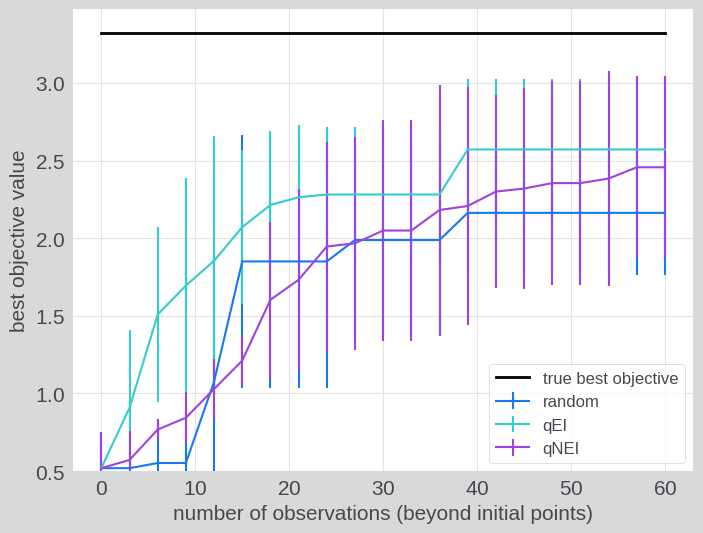

In [7]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = neg_hartmann6.optimal_value


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_ei)
y_nei = np.asarray(best_observed_all_nei)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_nei.mean(axis=0), yerr=ci(y_nei), label="qNEI", linewidth=1.5)
plt.plot(
    [0, N_BATCH * BATCH_SIZE],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")